In [150]:
from __future__ import division, absolute_import

import os
import sys
import random

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import h5py
import pickle
import numpy as np
import keras
import pandas as pd
import random
import time

from glob import glob
from keras.models import load_model
from keras import models
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import datetime
from plotnine import *

#root
absPath = '/home/angela/padding_EBI/'
sys.path.insert(0, absPath)

from src.Target import Target

#para no imprimir warnings chungos
import warnings 
warnings.simplefilter("ignore")

np.random.seed(1)
random.seed(1)
%matplotlib inline

In [2]:
list_paddings = ['ext_padding', 'mid_padding', 'post_padding', 'pre_padding', 
                 'rnd_padding', 'strf_padding',  "zoom_padding"]

task = 'task1/'
nfolds = 10
folder = 'EC_number/archaea/1conv/64filts_size5/'
nshape = (1, 1000, 26)
nlayer = 2

In [316]:
def search_model (folder, fold, task, padding):
    model_path = "".join((absPath, "data/checkpoint/", folder, task, list_paddings[2], "/", "1", "/"))
    model_file = glob(os.path.join(model_path, "weights-*.hdf5"))[0]
    return model_file

def random_prot_idx(folder, task):
    if task == "task1":
        file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_split.pickle')
    else:
        file_idcs = os.path.join(absPath, 'data/', folder, 'idcs_data_enz.pickle')
    with open(file_idcs, "rb") as input_file:
        splitting_sets = pickle.load(input_file)[0]
    i_train, i_val, i_test = splitting_sets
    len_test = len(i_test)
    rnd_index = random.randint(0, len_test-1)
    protein_index = i_test[rnd_index]
    return protein_index

def load_prot(folder, protein_index, padding, labels_label, newshape):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    prot = f1[padding][protein_index]
    label_prot = f1[labels_label][protein_index]
    instarget = Target('AAAAAA')
    aa_to_int = instarget.predefining_dict()
    seq_onehot = instarget.int_to_onehot(list(prot), len(aa_to_int))
    seq_reshaped = np.reshape(seq_onehot, newshape=newshape)
    return seq_reshaped, label_prot

def obtain_activations(model_path, n_layer, seq_reshaped):
    model = load_model(model_path)
    layer_output = model.layers[n_layer].output
    activation_model = models.Model(inputs=model.input, outputs=layer_output) 
    activations = activation_model.predict(seq_reshaped, batch_size=1)
    shape_act = activations.shape
    activations_reshaped = np.reshape(activations, newshape=(shape_act[2], shape_act[1]))
    #print(activations_reshaped.shape)
    return activations_reshaped

def activations_to_df(activations, padding, fold):
    activations_df = pd.DataFrame(activations)
    activations_df["padding"] = padding
    activations_df["order"] = list(range(0,activations.shape[0]))
    activations_df["fold"] = fold
    #label_prot_noonehot = np.argmax(label_prot, -1)
    #activations_df["label"] = label_prot_noonehot
    return activations_df

def train_pca(list_dfs, ncomps):
    df_joint = pd.concat(list_dfs, ignore_index=True)
    x = df_joint.drop(['order', 'padding', 'fold', "enzyme_type",
                       #, 'label'
                      ], axis=1).values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=ncomps)
    pca.fit(x)
    principalComponents = pca.fit_transform(x)
    principal_df = pd.DataFrame(principalComponents, columns=["PC1", "PC2"])
    final_df = pd.concat([principal_df, df_joint[['padding']], df_joint[['order']],df_joint[['fold']], 
                          df_joint[["enzyme_type"]]], 
                          axis=1)
    return final_df, pca

def plot_pca(df, pca, type_plot, list_paddings=None):
    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(1,1,1) 
    label_x = " ".join(("Principal Component 1 (", str(round(pca.explained_variance_ratio_[0]*100, 2)), "%)"))
    label_y = " ".join(("Principal Component 2 (", str(round(pca.explained_variance_ratio_[1]*100, 2)), "%)"))
    ax.set_xlabel(label_x, fontsize = 11)
    ax.set_ylabel(label_y, fontsize = 11)
    ax.set_title('PCA of Conv1D (size=5)', fontsize = 14)
    
    if type_plot == "padding":
        colors = ["#FFED6F","#BEBADA","#FB8072","#80B1D3","#FDB462","#B3DE69",
             "#FCCDE5"]
        for padding, color in zip(list_paddings,colors):
            indicesToKeep = df['padding'] == padding
            print(padding, df.loc[indicesToKeep, 'PC1'].shape)
            ax.scatter(df.loc[indicesToKeep, 'PC1']
                   , df.loc[indicesToKeep, 'PC2']
                   , c = color
                   , s = 25,
                      alpha=1)
        ax.legend(list_paddings, title = "Padding type")
        ax.grid()
    elif type_plot == "enzyme_type":
        types_enzymes = list(range(1,8))
        colors = ["#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", "#E5C494"]
        for enz_type, color in zip(types_enzymes,colors):
            indicesToKeep = df['enzyme_type'] == enz_type
            #print(enz_type, df.loc[indicesToKeep, 'PC1'].shape)
            ax.scatter(df.loc[indicesToKeep, 'PC1']
               , df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 25,
                  alpha=0.8)
        ax.legend(types_enzymes, title = "Enzyme type")
        ax.grid()
    else:
        ax.scatter(df.loc[:, 'PC1'], df.loc[:, 'PC2'], 
                   c=df.loc[:, 'sequence_length'], edgecolor='none', alpha=0.7)
        im = plt.gca().get_children()[0]
        cax = fig.add_axes([1,0.1,0.03,0.8]) 
        clb=fig.colorbar(im, cax=cax)  
        clb.ax.set_title("Protein sequence length")
        ax.grid()
    
#function to select proteins of the test set with an specific enzimatic label
def find_prot_labeled(folder, enz_label, quant=2, task = "task2", labels_label = "labels_task2"):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    indices_enzymes = []
    while len(indices_enzymes)<quant:
        idx = random_prot_idx(folder, task)
        label_prot = np.argmax(f1[labels_label][idx]) + 1
        if label_prot == enz_label:
            indices_enzymes.append(idx)
    return indices_enzymes

def load_prot_labeled(folder, padding, newshape, enz_label, idx):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    instarget = Target('AAAAAA')
    aa_to_int = instarget.predefining_dict()
    prot = f1[padding][idx]
    seq_onehot = instarget.int_to_onehot(list(prot), len(aa_to_int))
    seq_reshaped = np.reshape(seq_onehot, newshape=newshape)
    return seq_reshaped

def plot_pca_per_padding(final_df, pca, plot_by = "factor(enzyme_type)"):
    p = (ggplot(final_df, aes(x="PC1", y="PC2", color=plot_by))
    + geom_jitter(alpha=0.8, size=1)
     #+ scale_color_brewer(palette="Set2", type='qual', name="enzyme type")
    + theme_bw()
    + facet_wrap("~padding", nrow=4, ncol=2)
    +theme(figure_size=(8,8), axis_text_y =element_text(size=9),
                legend_text=element_text(size=12), strip_text_x = element_text(size=9), 
               strip_text_y = element_text(size=9), plot_title = element_text(size=14), 
           #axis_title_y = element_blank(),
               axis_title_x = element_text(size = 11), legend_key_size = 12,
           axis_title_y = element_text(size = 11),
                legend_box="horizontal")
    +ggtitle('PCA of Conv1D (size=5)')
    + xlab(" ".join(("Principal Component 1 (", str(round(pca.explained_variance_ratio_[0]*100, 2)), "%)")))
    +ylab(" ".join(("Principal Component 2 (", str(round(pca.explained_variance_ratio_[1]*100, 2)), "%)"))))
    
    if plot_by == "factor(enzyme_type)":
        q = p + scale_color_brewer(palette="Set2", type='qual', name="enzyme type")
    else:
        q = p
    return q

def density_facet(final_df, pca):
    p = (ggplot(final_df, aes(x="PC1", y="PC2", fill="factor(enzyme_type)"))
    #+ geom_density_2d(aes(fill="..level..", levels=10, alpha=0.8))
    # +geom_point()
     + stat_density_2d(aes(alpha="stat(level)"), color="black", geom="polygon")
     + scale_fill_brewer(palette="Set2", type='qual', name="enzyme type")
     #+ scale_fill_gradient(low = "")
    + theme_bw()
     + facet_grid("enzyme_type~padding")
    #+ facet_grid("~padding", nrow=4, ncol=2)
    +theme(figure_size=(10,10), axis_text_y =element_text(size=9),
                legend_text=element_text(size=12), strip_text_x = element_text(size=9), 
       #axis_text_x = element_blank(),
               strip_text_y = element_text(size=9), plot_title = element_text(size=14), 
           #axis_title_y = element_blank(),
               axis_title_x = element_text(size = 11), legend_key_size = 12,
           axis_title_y = element_text(size = 11),
       #legend_position="bottom", 
                legend_box="horizontal")
    +ggtitle('PCA of Conv1D (size=5)')
    + xlab(" ".join(("Principal Component 1 (", str(round(pca.explained_variance_ratio_[0]*100, 2)), "%)")))
    +ylab(" ".join(("Principal Component 2 (", str(round(pca.explained_variance_ratio_[1]*100, 2)), "%)"))))
    return p

#pintar loadings
def plot_loadings(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(10,10))
    #plt.scatter(xs * scalex,ys * scaley, 
    #           # c = y
    #           )
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-0.1,0.1)
    plt.ylim(-0.1,0.1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    
def int_to_aa(x_int, diccionario):
    """Translate a list of integer numbers to a sequence of amino acids, given a dictionary"""
    result = []   
    for j in x_int:
        if j == 0:
            result.append("0")
        else:
            result.append(list(diccionario.keys())[list(diccionario.values()).index(j)])
    return result

def load_prot_aminoacids(folder, protein_index, padding, labels_label):
    data_path = os.path.join(absPath, "data/", folder, "data.h5")
    f1 = h5py.File(data_path, 'r')
    prot = f1[padding][protein_index]
    instarget = Target('AAAAAA')
    seq_int = f1[padding][protein_index]
    aa_to_int = instarget.predefining_dict()
    sequence_aas = int_to_aa(seq_int, aa_to_int)
    label_prot = f1[labels_label][protein_index]
    return sequence_aas, label_prot

def add_sequences_length(final_df, df_indices):
    len_len_seq = int((len(final_df)/7)/2)
    print(len_len_seq)
    lista_lengths = []
    for idx, row in df_indices.iterrows():
        len_seq = row["len_seq"]
        lista_lengths.append([len_seq]*len_len_seq)
    lista_lengths_unnested = [item for sublist in lista_lengths for item in sublist]
    print(len(lista_lengths_unnested))
    print(final_df.info())
    final_df["sequence_length"] = lista_lengths_unnested
    return final_df

## Task 2

In [4]:
prots_pca = []
list_indices_enzymes = []
for enz_label in range(1,8):
    indices_enzymes = find_prot_labeled(folder, enz_label)
    print(indices_enzymes, enz_label)
    list_indices_enzymes.append((indices_enzymes, enz_label))
    for idx,i in enumerate(indices_enzymes):
        for padding in list_paddings:
            seq = load_prot_labeled(folder, padding, nshape, enz_label, i)
            prots_pca.append((seq,enz_label, padding))
            #print(enz_label, "prot", idx)

[17828, 18097] 1
[18234, 3639] 2
[18624, 10859] 3
[10809, 5232] 4
[6482, 6602] 5
[8546, 16129] 6
[11613, 16508] 7


In [5]:
#Define list of dataframes
#HACIENDOLO SOLO CON UNA TASK
task = "task2/"
fold = 5
lista_dfs = []
for tup in prots_pca:
    model_type = tup[2]
    enz_type = tup[1]
    prot = tup[0]
    #print("Model type: ", model_type, "enzyme type", enz_type)
    model = search_model(folder, str(fold), task, model_type)
    #writing log file 
    print('Model type: %s \n' % model_type)
    print('Enzyme type: %s \n' % enz_type)
    formatted_time = datetime.datetime.now()
    print('Starting time: %s \n' % formatted_time)
    activations = obtain_activations(model, nlayer, prot)
    act_df = activations_to_df(activations, model_type, fold)
    act_df["enzyme_type"] = tup[1]
    formatted_endtime = datetime.datetime.now()
    print('Finishing time: %s \n' % formatted_endtime)
    lista_dfs.append(act_df)

Model type: ext_padding 

Enzyme type: 1 

Starting time: 2019-10-08 17:15:42.197436 

Finishing time: 2019-10-08 17:15:43.097616 

Model type: mid_padding 

Enzyme type: 1 

Starting time: 2019-10-08 17:15:43.098532 

Finishing time: 2019-10-08 17:15:44.043800 

Model type: post_padding 

Enzyme type: 1 

Starting time: 2019-10-08 17:15:44.044344 

Finishing time: 2019-10-08 17:15:45.006056 

Model type: pre_padding 

Enzyme type: 1 

Starting time: 2019-10-08 17:15:45.006808 

Finishing time: 2019-10-08 17:15:46.150258 

Model type: rnd_padding 

Enzyme type: 1 

Starting time: 2019-10-08 17:15:46.150858 

Finishing time: 2019-10-08 17:15:47.446815 

Model type: strf_padding 

Enzyme type: 1 

Starting time: 2019-10-08 17:15:47.447660 

Finishing time: 2019-10-08 17:15:48.752165 

Model type: zoom_padding 

Enzyme type: 1 

Starting time: 2019-10-08 17:15:48.752754 

Finishing time: 2019-10-08 17:15:50.299426 

Model type: ext_padding 

Enzyme type: 1 

Starting time: 2019-10-08 17:1

Finishing time: 2019-10-08 17:21:05.630174 

Model type: ext_padding 

Enzyme type: 5 

Starting time: 2019-10-08 17:21:05.631027 

Finishing time: 2019-10-08 17:21:15.492383 

Model type: mid_padding 

Enzyme type: 5 

Starting time: 2019-10-08 17:21:15.492911 

Finishing time: 2019-10-08 17:21:25.812186 

Model type: post_padding 

Enzyme type: 5 

Starting time: 2019-10-08 17:21:25.812656 

Finishing time: 2019-10-08 17:21:36.421190 

Model type: pre_padding 

Enzyme type: 5 

Starting time: 2019-10-08 17:21:36.421646 

Finishing time: 2019-10-08 17:21:47.084004 

Model type: rnd_padding 

Enzyme type: 5 

Starting time: 2019-10-08 17:21:47.084683 

Finishing time: 2019-10-08 17:21:58.035670 

Model type: strf_padding 

Enzyme type: 5 

Starting time: 2019-10-08 17:21:58.036118 

Finishing time: 2019-10-08 17:22:09.142991 

Model type: zoom_padding 

Enzyme type: 5 

Starting time: 2019-10-08 17:22:09.143563 

Finishing time: 2019-10-08 17:22:20.364459 

Model type: ext_padding 

En

In [236]:
#investigar dfs

len(lista_dfs)

98

In [8]:
lista_dfs[0].shape

(64, 1004)

In [9]:
# ha tardado un huevo en ejecutarse asi que deberia guardarlo
filename = "activations_enzymeType_1fold.pickle"
pickle_path = "".join((absPath, "data/results/", task, filename))

with open(pickle_path, 'wb') as handle:
    pickle.dump(lista_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
lista_dfs[0].columns

Index([            0,             1,             2,             3,
                   4,             5,             6,             7,
                   8,             9,
       ...
                 994,           995,           996,           997,
                 998,           999,     'padding',       'order',
              'fold', 'enzyme_type'],
      dtype='object', length=1004)

In [141]:
final_df, pca = train_pca(lista_dfs, 2)

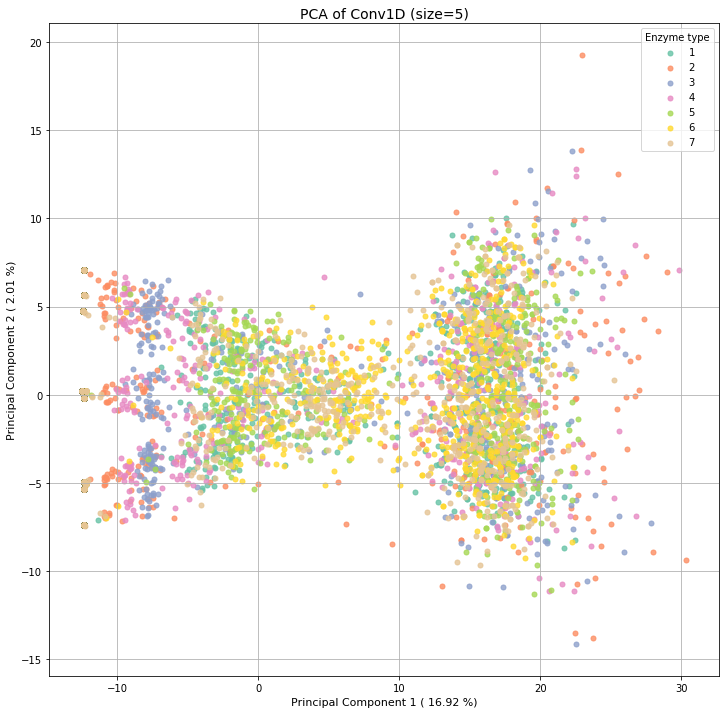

In [171]:
plot_pca(final_df, pca, "enzyme_type")

ext_padding (896,)
mid_padding (896,)
post_padding (896,)
pre_padding (896,)
rnd_padding (896,)
strf_padding (896,)
zoom_padding (896,)


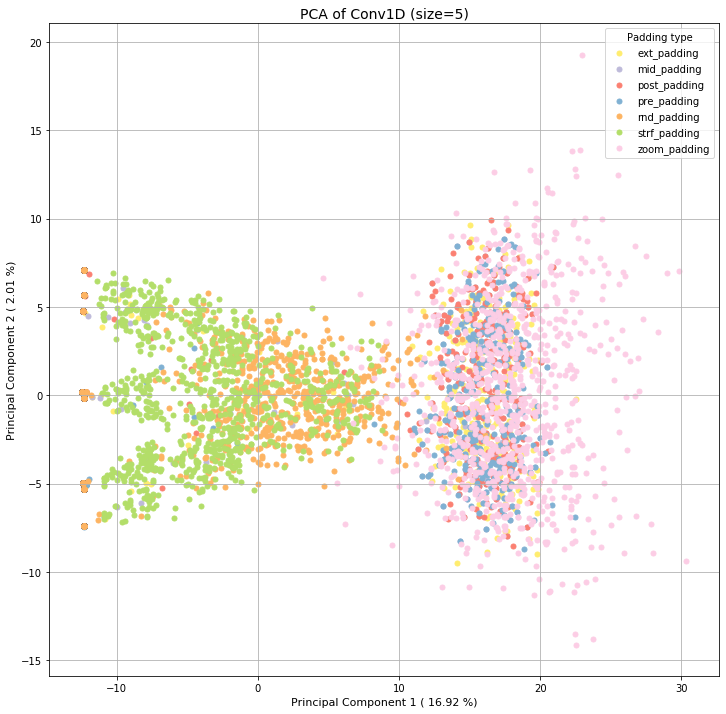

In [172]:
plot_pca(final_df, pca, "padding", list_paddings)

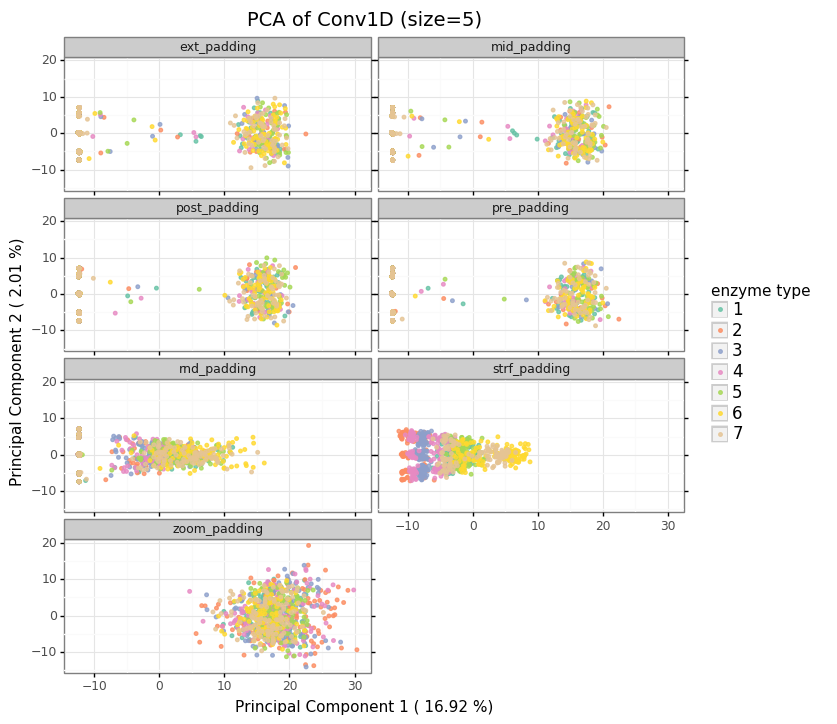

<ggplot: (-9223363244654408637)>

In [173]:
plot_pca_per_padding(final_df, pca)

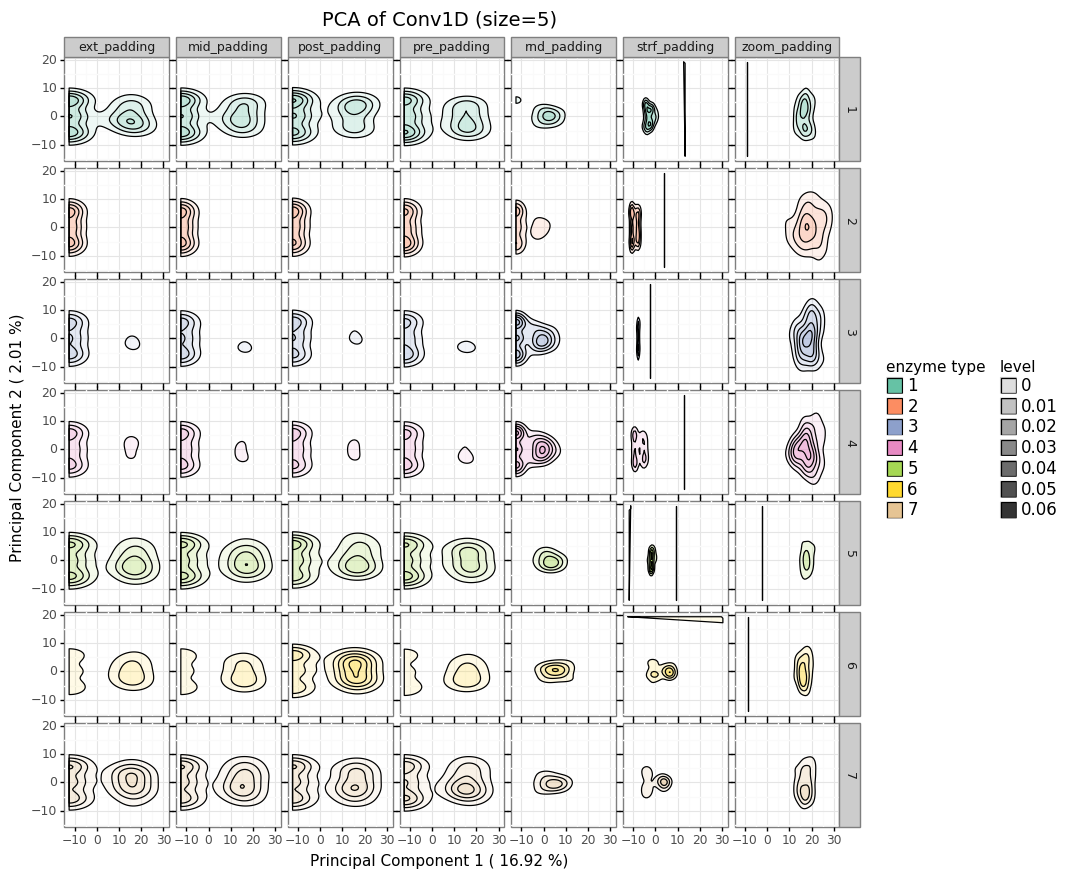

<ggplot: (-9223363244654727059)>

In [174]:
density_facet(final_df, pca)

In [192]:
#esto se deberia hacer automaticamente
df_indices = pd.DataFrame(columns=["indices", "enz_type", "len_seq"])
df_indices["indices"] = [17828, 18097, 18234, 3639, 18624, 10859, 10809, 5232, 
                         6482, 6602, 8546, 16129, 11613, 16508]
df_indices["enz_type"] = [1,1,2,2,3,3,4,4,5,5,6,6,7,7]

In [202]:
padding = "post_padding"
for idx, row in df_indices.iterrows():
    prot_idx = row["indices"]
    prot, label = load_prot_aminoacids(folder, prot_idx, padding, "labels_task2")
    len_seq = len([idx for idx, i in enumerate(prot) if i != '0'])
    df_indices.loc[idx, "len_seq"] = len_seq

In [278]:
final_df = add_sequences_length(final_df, df_indices)

448
6272
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 7 columns):
PC1                6272 non-null float32
PC2                6272 non-null float32
padding            6272 non-null object
order              6272 non-null int64
fold               6272 non-null int64
enzyme_type        6272 non-null int64
sequence_length    6272 non-null int64
dtypes: float32(2), int64(4), object(1)
memory usage: 294.1+ KB
None


In [279]:
final_df.head()

,PC1,PC2,padding,order,fold,enzyme_type,sequence_length
0,-12.175258,-5.073585,ext_padding,0,5,1,335
1,-12.344453,-7.367478,ext_padding,1,5,1,335
2,-12.360456,-4.934031,ext_padding,2,5,1,335
3,-12.313205,-0.174111,ext_padding,3,5,1,335
4,-12.403505,4.768456,ext_padding,4,5,1,335


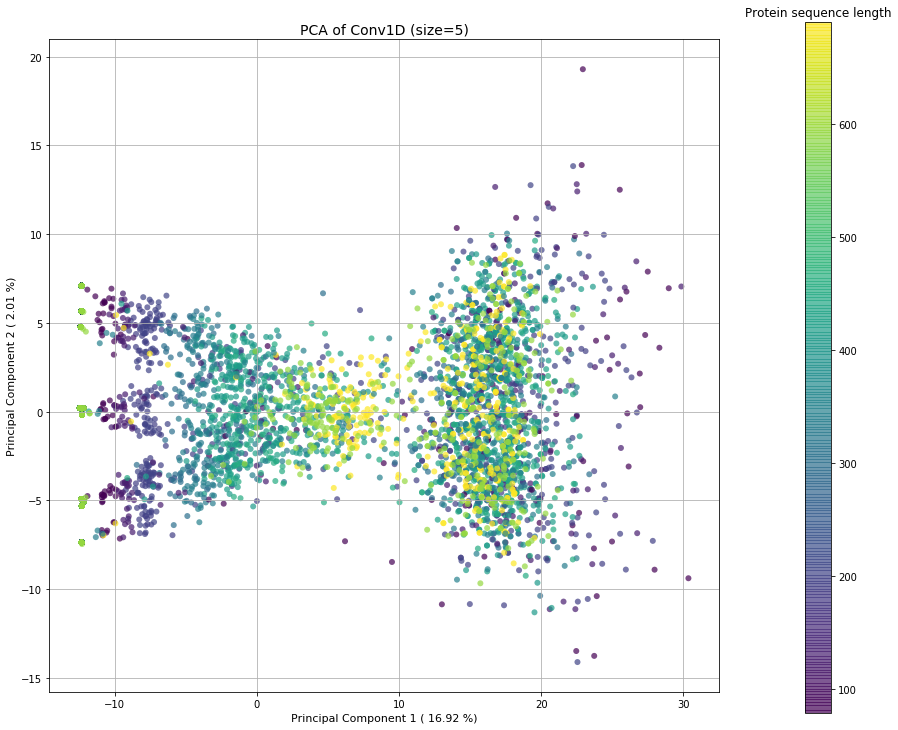

In [227]:
plot_pca(final_df, pca, "seq_len", None)

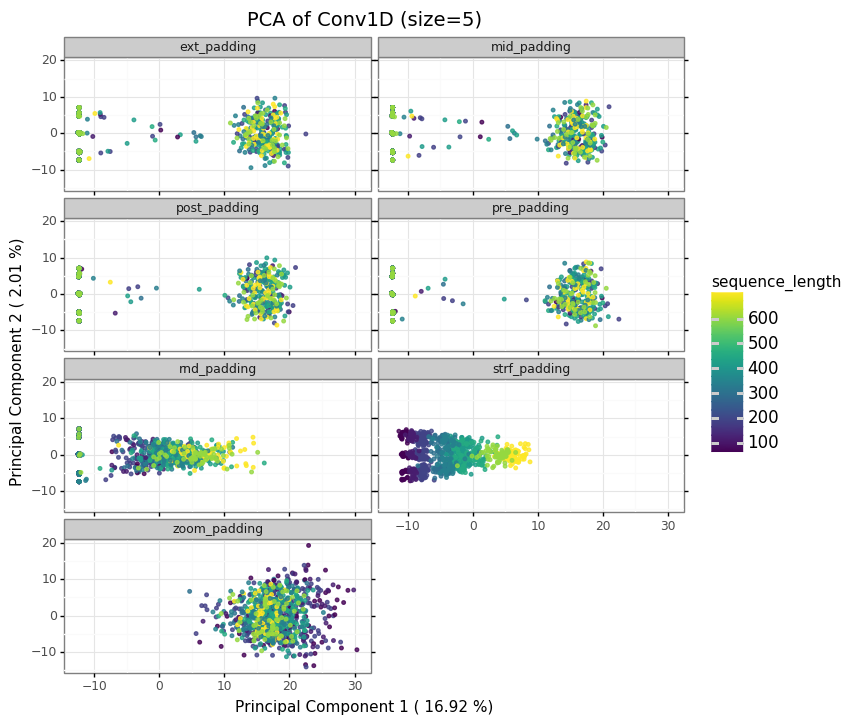

<ggplot: (8792222288206)>

In [286]:
plot_pca_per_padding(final_df, pca, "sequence_length")

In [308]:
#mirar los loadings: 2 componentes, una donde el tipo se mezcla o otra en la que no

In [309]:
#cambiar respecto a la nueva funcion de train_pca
df_joint = pd.concat(lista_dfs, ignore_index=True)
x = df_joint.drop(['order', 'padding', 'fold', "enzyme_type",
                       #, 'label'
                      ], axis=1).values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
pca.fit(x)
principalComponents = pca.fit_transform(x)

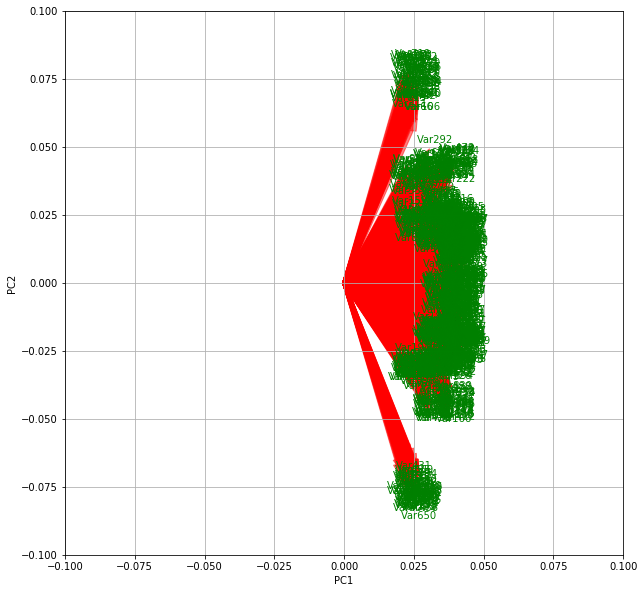

In [310]:
myplot(principalComponents, np.transpose(pca.components_))

In [315]:
# guardamos final_df en un csv
task = "task2/"
filename = "pca_1fold.csv"
pickle_path = "".join((absPath, "data/results/", task, filename))

#with open(pickle_path, 'wb') as handle:
#    pickle.dump(final_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

final_df.to_csv(pickle_path)

## Task 1

In [ ]:
#mismo pca para enzima/no enzima

In [311]:
task = "task1/"
fold = 5
lista_dfs_task1 = []
for tup in prots_pca:
    model_type = tup[2]
    enz_type = tup[1]
    prot = tup[0]
    #print("Model type: ", model_type, "enzyme type", enz_type)
    model = search_model(folder, str(fold), task, model_type)
    #writing log file 
    print('Model type: %s \n' % model_type)
    print('Enzyme type: %s \n' % enz_type)
    formatted_time = datetime.datetime.now()
    print('Starting time: %s \n' % formatted_time)
    activations = obtain_activations(model, nlayer, prot)
    act_df = activations_to_df(activations, model_type, fold)
    act_df["enzyme_type"] = tup[1]
    formatted_endtime = datetime.datetime.now()
    print('Finishing time: %s \n' % formatted_endtime)
    lista_dfs.append(act_df)

Model type: ext_padding 

Enzyme type: 1 

Starting time: 2019-10-11 11:36:33.032783 

Finishing time: 2019-10-11 11:38:07.623403 

Model type: mid_padding 

Enzyme type: 1 

Starting time: 2019-10-11 11:38:07.624224 

Finishing time: 2019-10-11 11:38:25.274223 

Model type: post_padding 

Enzyme type: 1 

Starting time: 2019-10-11 11:38:25.275053 

Finishing time: 2019-10-11 11:38:43.442238 

Model type: pre_padding 

Enzyme type: 1 

Starting time: 2019-10-11 11:38:43.442895 

Finishing time: 2019-10-11 11:39:01.845718 

Model type: rnd_padding 

Enzyme type: 1 

Starting time: 2019-10-11 11:39:01.846721 

Finishing time: 2019-10-11 11:39:20.300407 

Model type: strf_padding 

Enzyme type: 1 

Starting time: 2019-10-11 11:39:20.301361 

Finishing time: 2019-10-11 11:39:38.719853 

Model type: zoom_padding 

Enzyme type: 1 

Starting time: 2019-10-11 11:39:38.720512 

Finishing time: 2019-10-11 11:39:57.265709 

Model type: ext_padding 

Enzyme type: 1 

Starting time: 2019-10-11 11:3

Finishing time: 2019-10-11 12:05:31.830468 

Model type: ext_padding 

Enzyme type: 5 

Starting time: 2019-10-11 12:05:31.831272 

Finishing time: 2019-10-11 12:06:06.400035 

Model type: mid_padding 

Enzyme type: 5 

Starting time: 2019-10-11 12:06:06.400678 

Finishing time: 2019-10-11 12:06:41.116030 

Model type: post_padding 

Enzyme type: 5 

Starting time: 2019-10-11 12:06:41.116792 

Finishing time: 2019-10-11 12:07:19.103288 

Model type: pre_padding 

Enzyme type: 5 

Starting time: 2019-10-11 12:07:19.104083 

Finishing time: 2019-10-11 12:07:54.321932 

Model type: rnd_padding 

Enzyme type: 5 

Starting time: 2019-10-11 12:07:54.322630 

Finishing time: 2019-10-11 12:08:29.944314 

Model type: strf_padding 

Enzyme type: 5 

Starting time: 2019-10-11 12:08:29.944970 

Finishing time: 2019-10-11 12:09:05.890394 

Model type: zoom_padding 

Enzyme type: 5 

Starting time: 2019-10-11 12:09:05.891021 

Finishing time: 2019-10-11 12:09:42.115111 

Model type: ext_padding 

En

In [313]:
# ha tardado un huevo en ejecutarse asi que deberia guardarlo
#filename = "activations_enzymeType_1fold.pickle"
#pickle_path = "".join((absPath, "data/results/", task, filename))

#with open(pickle_path, 'wb') as handle:
#    pickle.dump(lista_dfs_task1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#coger al azar 7 enzimas y 7 no enzimas para comparar
prots_pca_task1 = []
list_indices_enzymes_task1 = []
for enz_label in [0,1]:
    indices_enzymes_task1 = find_prot_labeled(folder, enz_label, 7, "task1", "labels_task1")
    print(indices_enzymes_task1, enz_label)
    list_indices_enzymes_task1.append((indices_enzymes_task1, enz_label))
    for idx,i in enumerate(indices_enzymes_task1):
        for padding in list_paddings:
            seq = load_prot_labeled(folder, padding, nshape, enz_label, i)
            prots_pca.append((seq, enz_label, padding))
            #print(enz_label, "prot", idx)

In [ ]:
indices_task1find_prot_labeled(folder, enz_label, quant=2, task = "task2", labels_label = "labels_task2")